## Data preprocessing

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import json

# Hyperparameters for image size and batch size.
img_size = 128
batch_size = 128

# Define image transformations.
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)), 
    transforms.ToTensor(),          
])

data_dir = "data/tiny-imagenet-200/"
words_file = "data/tiny-imagenet-200/words.txt"

# Create dataset and data loader.
data = ImageFolder(root=f"{data_dir}/train", transform=transform)
train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, num_workers=0)

# Read words.txt to map wnid to name
wnid_to_text = {}
with open(words_file, "r") as f:
    for line in f:
        wnid, name = line.strip().split("\t")
        wnid_to_text[wnid] = name.split(",")[0]

# Build a mapping from numerical class index to text prompt.
# Note: data.classes contains the folder names (wnids).
targets_names = {}
for idx, wnid in enumerate(data.classes):
    targets_names[int(idx)] = wnid_to_text[wnid]

json.dump(targets_names, open("targets_names.json", "w"), indent=4)

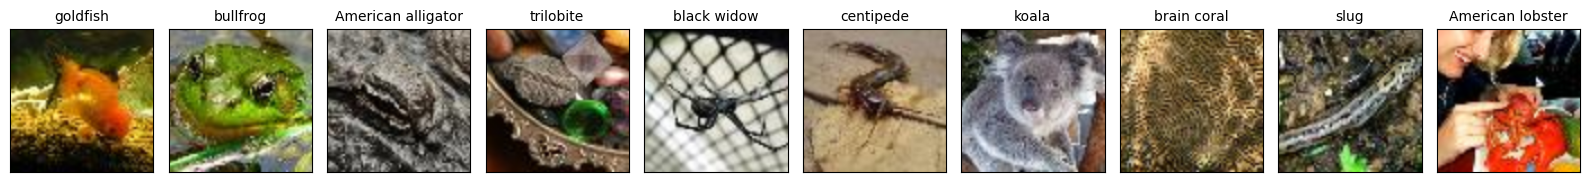

In [14]:
import matplotlib.pyplot as plt

# Preview sample images
fig = plt.figure(figsize=(16, 3))
for i in range(10):
    k = (i*1000) + 1
    ax = fig.add_subplot(1, 10, i+1, xticks=[], yticks=[])
    ax.imshow(data[k][0].permute(1,2,0))
    name = targets_names[data[k][1]]
    ax.set_title(name, fontsize=10)  
plt.tight_layout()
plt.show()

## Text Encoding

Embedding size: 512

In [3]:
!pip install openai-clip

In [4]:
import clip

class TextEncoder(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.device = device

        # Load OpenAI CLIP model
        self.model, _ = clip.load("ViT-B/32", device=self.device)

    def forward(self, text):
        # Tokenize the text
        text = clip.tokenize(text).to(self.device)

        # Generate the embedding
        with torch.no_grad():
            text_features = self.model.encode_text(text)

        # Normalize the features
        text_features /= text_features.norm(dim=-1, keepdim=True)

        return text_features.cpu().numpy()[0]
    

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

text_encoder = TextEncoder(device)
with open('targets_names.json', 'r') as f:
    targets_names = json.load(f)

embeddings = {} 
for k, name in targets_names.items():
    embeddings[int(k)] = text_encoder(['a photo of a' + name]).tolist()

with open('embeddings_names.json', 'w') as f:
    json.dump(embeddings, f)

## Conditional UNet


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConditionalBatchNorm2d(nn.Module):
    """
    Conditional Batch Normalization.
    Applies BatchNorm to the input and modulates the normalized features using
    a conditioning vector. The conditioning vector is projected to produce
    scale (gamma) and shift (beta) parameters.
    """
    def __init__(self, num_features, cond_dim):
        super().__init__()
        self.bn = nn.BatchNorm2d(num_features, affine=False)
        self.fc = nn.Linear(cond_dim, num_features * 2)
        # Initialize fc so that gamma starts at 0 (i.e. 1 + 0 = 1 scaling)
        nn.init.zeros_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)

    def forward(self, x, cond):
        x_norm = self.bn(x)
        gamma_beta = self.fc(cond)
        gamma, beta = gamma_beta.chunk(2, dim=1)
        gamma = gamma.unsqueeze(-1).unsqueeze(-1)
        beta = beta.unsqueeze(-1).unsqueeze(-1)
        return (1 + gamma) * x_norm + beta

class ResBlock(nn.Module):
    """
    Residual block with conditional BatchNorm.
    """
    def __init__(self, in_channels, out_channels, cond_dim, dropout=0.0):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.norm1 = ConditionalBatchNorm2d(out_channels, cond_dim)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.norm2 = ConditionalBatchNorm2d(out_channels, cond_dim)
        self.activation = nn.SiLU()  # Alternatively, nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1) \
                        if in_channels != out_channels else nn.Identity()

    def forward(self, x, cond):
        h = self.conv1(x)
        h = self.norm1(h, cond)
        h = self.activation(h)
        h = self.conv2(h)
        h = self.norm2(h, cond)
        h = self.activation(h)
        h = self.dropout(h)
        return h + self.shortcut(x)

class Downsample(nn.Module):
    """
    Downsampling via strided convolution.
    """
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, kernel_size=3, stride=2, padding=1)
        
    def forward(self, x):
        return self.conv(x)

class Upsample(nn.Module):
    """
    Upsampling via nearest neighbor interpolation followed by a convolution.
    """
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        
    def forward(self, x):
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        return self.conv(x)

class DownConditional(nn.Module):
    """
    A composite down block: a conditional residual block followed by downsampling.
    It returns both the skip (pre-downsample) and the downsampled feature.
    """
    def __init__(self, in_channels, out_channels, cond_dim, dropout=0.0):
        super().__init__()
        self.res = ResBlock(in_channels, out_channels, cond_dim, dropout)
        self.down = Downsample(out_channels)
        
    def forward(self, x, cond):
        x_res = self.res(x, cond)
        x_down = self.down(x_res)
        return x_res, x_down

class UpConditional(nn.Module):
    """
    A composite up block: upsample the input, concatenate with the corresponding skip,
    then apply a conditional residual block.
    """
    def __init__(self, in_channels, skip_channels, out_channels, cond_dim, dropout=0.0):
        super().__init__()
        self.up = Upsample(in_channels)
        self.res = ResBlock(in_channels + skip_channels, out_channels, cond_dim, dropout)
        
    def forward(self, x, skip, cond):
        x_up = self.up(x)
        x_cat = torch.cat([x_up, skip], dim=1)
        return self.res(x_cat, cond)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ConditionalUNet(nn.Module):
    """
    Clean Conditional U-Net with explicit layer definitions.
    Architecture:
      - Encoder: an initial ResBlock followed by 5 DownConditional blocks.
      - Bottleneck: a ResBlock that doubles the channels.
      - Decoder: 6 UpConditional blocks that fuse with corresponding skip connections.
      - Output: a final convolution to produce the denoised image.
      
    The skip connections are taken from:
        inc, down1, down2, down3, and down4,
    with down5 providing the deepest skip. The final up block fuses the output
    of the last up block with the initial features.
    """
    def __init__(self, in_channels=3, out_channels=3, base_ch=64, cond_dim=512):
        super().__init__()
        # Encoder
        self.inc = ResBlock(in_channels, base_ch, cond_dim)                       # -> base_ch
        self.down1 = DownConditional(base_ch, base_ch * 2, cond_dim)        # -> base_ch*2
        self.down2 = DownConditional(base_ch * 2, base_ch * 4, cond_dim)    # -> base_ch*4
        self.down3 = DownConditional(base_ch * 4, base_ch * 8, cond_dim)    # -> base_ch*8
        self.down4 = DownConditional(base_ch * 8, base_ch * 16, cond_dim)   # -> base_ch*16
        self.down5 = DownConditional(base_ch * 16, base_ch * 32, cond_dim)  # -> base_ch*32
        
        # Bottleneck
        self.bottleneck = ResBlock(base_ch * 32, base_ch * 64, cond_dim)  # -> base_ch*64
        
        # Decoder
        self.up1 = UpConditional(base_ch * 64, base_ch * 32, base_ch * 32, cond_dim)
        self.up2 = UpConditional(base_ch * 32, base_ch * 16, base_ch * 16, cond_dim)
        self.up3 = UpConditional(base_ch * 16, base_ch * 8, base_ch * 8, cond_dim)
        self.up4 = UpConditional(base_ch * 8, base_ch * 4, base_ch * 4, cond_dim)
        self.up5 = UpConditional(base_ch * 4, base_ch * 2, base_ch * 2, cond_dim)
        self.up6 = UpConditional(base_ch * 2, base_ch, base_ch, cond_dim)
        
        self.outc = nn.Conv2d(base_ch, out_channels, kernel_size=3, padding=1)
        
    def forward(self, x, cond):
        # Encoder
        x1 = self.inc(x)                      # features: base_ch
        x2, x2_down = self.down1(x1, cond)      # x2: base_ch*2
        x3, x3_down = self.down2(x2_down, cond) # x3: base_ch*4
        x4, x4_down = self.down3(x3_down, cond) # x4: base_ch*8
        x5, x5_down = self.down4(x4_down, cond) # x5: base_ch*16
        x6, x6_down = self.down5(x5_down, cond) # x6: base_ch*32
        º
        # Bottleneck
        bn = self.bottleneck(x6_down, cond)    # features: base_ch*64
        
        # Decoder (fusing with skip connections)
        u1 = self.up1(bn, x6, cond)             # -> base_ch*32
        u2 = self.up2(u1, x5, cond)             # -> base_ch*16
        u3 = self.up3(u2, x4, cond)             # -> base_ch*8
        u4 = self.up4(u3, x3, cond)             # -> base_ch*4
        u5 = self.up5(u4, x2, cond)             # -> base_ch*2
        u6 = self.up6(u5, x1, cond)             # -> base_ch
        
        return self.outc(u6)


## Diffusion Process

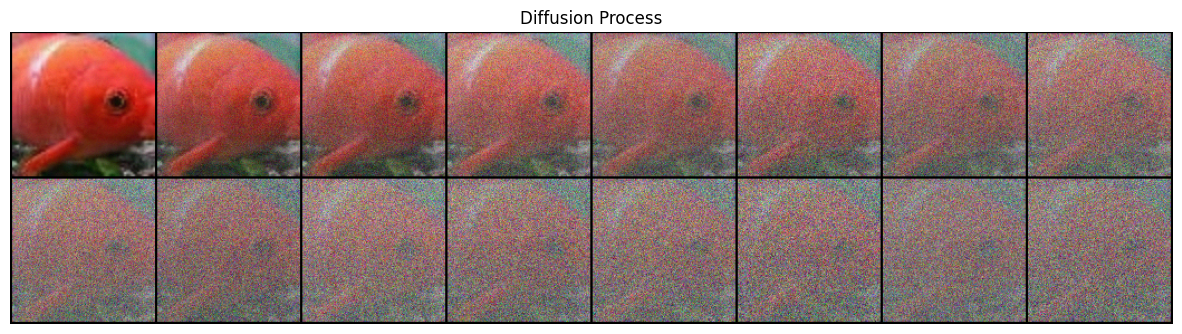

In [94]:
import torch
import torchvision.utils as vutils
import matplotlib.pyplot as plt

class Diffusion:
    def __init__(self, timesteps=1000, beta_start=1e-4, beta_end=0.05, device='cuda'):
        """
        Initializes the diffusion process with a linear beta schedule.
        
        Args:
            timesteps (int): Total number of diffusion steps.
            beta_start (float): Starting value of beta.
            beta_end (float): Ending value of beta.
            device (str): Device to use (e.g., 'cuda' or 'cpu').
        """
        self.timesteps = timesteps
        self.device = device
        
        # Create a linear schedule for betas and compute corresponding alphas.
        self.betas = torch.linspace(beta_start, beta_end, timesteps, device=device)
        self.alphas = 1.0 - self.betas
        self.alpha_hat = torch.cumprod(self.alphas, dim=0)  # cumulative product: α̂_t

    def forward_diffusion(self, x0, t):
        """
        Applies the forward diffusion process to an image x0 at timestep t.
        
        Args:
            x0 (tensor): Original image tensor of shape (B, C, H, W).
            t (int or tensor): Timestep(s) at which to add noise.
            
        Returns:
            x_t (tensor): Noisy image at timestep t.
        """
        # Ensure t is a tensor on the proper device and has a batch entry per image.
        if not torch.is_tensor(t):
            t = torch.tensor([t] * x0.size(0), device=self.device)
        else:
            t = t.to(self.device)
        
        # Compute the scaling factors for the image and the noise.
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t]).view(-1, 1, 1, 1)
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t]).view(-1, 1, 1, 1)
        
        # Sample random Gaussian noise.
        noise = torch.randn_like(x0, device=self.device)
        
        # Return the noised image.
        return sqrt_alpha_hat * x0 + sqrt_one_minus_alpha_hat * noise

    def sample_noise_process(self, x0):
        """
        Generates a series of images representing different timesteps in the diffusion process.
        
        Args:
            x0 (tensor): Original image tensor of shape (1, C, H, W).
            num_steps (int): Number of timesteps to sample between 0 and timesteps-1.
        
        Returns:
            List[tensor]: A list of noisy images.
        """
        # Select evenly spaced timesteps for visualization.
        steps = torch.linspace(0, self.timesteps - 1, self.timesteps, dtype=torch.long)
        images = []
        for t in steps:
            images.append(self.forward_diffusion(x0, t.item()))
        return images

# ----------------------------------------------
# Visualization of the diffusion process
# ----------------------------------------------

diffusion = Diffusion(timesteps=16, device=device)

x0, _ = data[128]
x0 = x0.unsqueeze(0).to(device)

noisy_images = diffusion.sample_noise_process(x0)

grid = vutils.make_grid(torch.cat(noisy_images, dim=0), nrow=8, normalize=True, scale_each=True)
plt.figure(figsize=(15, 8))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.title("Diffusion Process")
plt.show()
